#Seminar 2
The task is to implement and compare two techniques of data compression for image retrieval: product quantization(PQ) and optimized product quantization(OPQ).
The data is a small subset of Tiny Images Dataset.
The search will be performed on the data from **gist.mat** file, which contains GIST descriptors (arrays with length of 384), and **images.mat** contains images (32x32x3 array) included here for the purpose of visualization.

Download the data from https://yadi.sk/d/uIPiP7aqek63v

In [1]:
%matplotlib inline
import numpy as np
import scipy.cluster.vq as vq
import scipy.linalg
import scipy.io
import matplotlib.pyplot as plt
import time
X = scipy.io.loadmat('gist.mat')['data'].transpose() #data(descriptors) loading
images = scipy.io.loadmat('images.mat')['im']
n = X.shape[0] #number of descriptors
m = X.shape[1] #descriptor dimensionalty

##Simple search
The following straightforward algorithm compares uncompressed descriptor of the query image with every descriptor in our collection. It's output will serve as ground thruth.  

In [2]:
from scipy.spatial.distance import cdist as cdist
def retrieve(query_ind):
    query = X[query_ind,:].reshape((1, X.shape[1]))
    dist = cdist(query, X).ravel()
    indices = np.argsort(dist)
    return indices

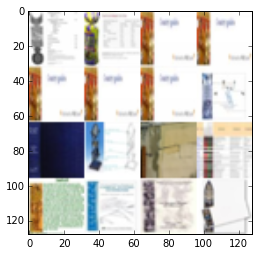

In [3]:
#visualization
def stripe_images(indices):
    return np.hstack((images[:,:,:,i] for i in indices))
def tile_images(indices):
    return np.vstack([stripe_images(indices[i:i+4]) for i in range(0,16,4)])

query_ind = 52
ret = retrieve(query_ind)
plt.imshow(tile_images(ret[:16]))
plt.show()

#Product Quantization
Compute codes and cluster centroids for product quantization. Use **scipy.cluster.vq.kmeans** or **scipy.cluster.vq.kmeans2** for clustering. This computation have to be done only once for given data.

In [4]:
k = 256  #number of clusters
c = 4   #number of subspaces
pq_codes = np.zeros((n, c))
pq_centroids = np.zeros((k, m/c, c))

In [32]:
thetime = time.time()
for i in xrange(c):
    #fill pq_codes and pq_centroids here
    #for each c calculate centroids for subspace and codes
    (pq_centroids[:,:,i], pq_codes[:,i]) = scipy.cluster.vq.kmeans2(X[:, i * m/c : (i + 1) * m/c], k)  
print time.time() - thetime

85.8934819698


In [31]:
#test
for pff in xrange(5):
    thetime = time.time()
    test_codes = np.zeros((n, c))
    test_centroids = np.zeros((k, m/c, c))
    for i in xrange(c):
        #fill pq_codes and pq_centroids here
        #for each c calculate centroids for subspace and codes
        (test_centroids[:,:,i], test_codes[:,i]) = scipy.cluster.vq.kmeans2(X[:, i * m/c : (i + 1) * m/c], k)
    testY = np.zeros(X.shape)
    for el in xrange(n):
        for subsp in xrange(c):
            testY[el, subsp * m / c : (subsp + 1) * m / c] = test_centroids[test_codes[el, subsp], :, subsp]  
    print np.linalg.norm(X - testY), np.linalg.norm(X), np.linalg.norm(testY)
    print time.time() - thetime

127.901878155 403.113 386.015150128
92.9238729477
127.925595373 403.113 386.007290318
92.9666471481
127.893574617 403.113 386.017901081
93.0428650379
127.962546587 403.113 385.995042594
93.0923149586
128.054670786 403.113 385.964490379
92.8025040627


Implement **pq_retrieve** function which performs seach using compressed data and returns indices ranked according to their distance to the query.

In [8]:
def pq_approx_dist(left, right):
    res = 0
    for i in xrange(c):
        res += cdist((pq_centroids[left[i],:,i],), (pq_centroids[right[i],:,i],)) ** 2
    return np.sqrt(res)

In [6]:
def pq_approx_dist_assym(query, right):
    res = 0
    for i in xrange(c):
        res += cdist((query[i * m / c : (i + 1) * m / c],), (pq_centroids[right[i],:,i],)) ** 2
    return res

In [9]:
def pq_retrieve(query_ind):
    # finding nearest centroid
    coeffs = np.zeros(c)
    for i in xrange(c):
        query = X[query_ind, i * m / c : (i + 1) * m / c].reshape((1, m / c))
        coeffs[i] = cdist(query, pq_centroids[:,:,i]).argmin()
    #print coeffs
    # calculating approx distances
    dist = np.zeros(n)
    for i in xrange(n):
        dist[i] = pq_approx_dist(coeffs, pq_codes[i])
    # returning result
    indices = np.argsort(dist)
    return indices

In [7]:
def pq_retrieve_assym(query_ind):
    # finding nearest centroid
    #print coeffs
    # calculating approx distances
    dist = np.zeros(n)
    for i in xrange(n):
        dist[i] = pq_approx_dist_assym(X[query_ind], pq_codes[i])
    # returning result
    indices = np.argsort(dist)
    return indices

Results should look similar to previous method's visualization.

47.501996994


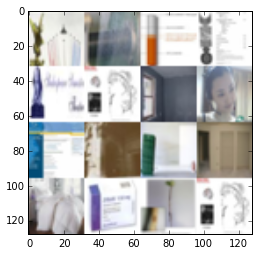

In [10]:
starttime = time.time()
pq_ret = pq_retrieve(query_ind)
print time.time() - starttime
plt.imshow(tile_images(pq_ret[:16]))
plt.show()

46.050661087


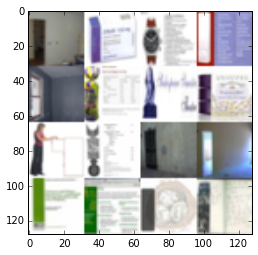

In [8]:
starttime = time.time()
pq_ret = pq_retrieve_assym(query_ind)
print time.time() - starttime
plt.imshow(tile_images(pq_ret[:16]))
plt.show()

#Optimized Product Quantization
Compute codes, centroids and rotation matrix for OPQ ([original article](http://research.microsoft.com/pubs/187499/cvpr13opq.pdf)).


The main idea of the algorithm is to update clustering and rotation iteratively. Clustering update can be done via one step of kmeans algorithm: **scipy.cluster.vq.kmeans2(..., ..., iter=1)**.
New rotation matrix is calculated on every iteration via singular value decomposition according to the solution of [Orthogonal Procrustes problem](http://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem)

$$
R=\text{argmin}\|XR-Y\| \quad \text{s.t.} \quad {R^TR=I}
$$

$$
X^TY = USV^T
$$

$$
R = UV^T
$$

Beware of **scipy.linalg.svd** which outputs $V^T$ instead of $V$.

Original article recommends performing 100 iterations. However, it's going to take too long unless you optimize your code cleverly or use small subset of training data. Anyway, 10 iterations will be enough to outperform PQ.  


In [9]:
k = 256  #number of clusters
c = 4   #number of subspaces
R = np.eye(m, m)
opq_codes = np.zeros((n, c))
opq_centroids = np.zeros((k, m/c, c))
iterations = 10

#fill R, opq_codes and opq_centroids

In [10]:
thetime = time.time()
for iteration in range(iterations):
    #learning codebooks
    for i in xrange(c):
        (opq_centroids[:,:,i], opq_codes[:,i]) = \
          scipy.cluster.vq.kmeans2(X.dot(R)[:, i * m/c : (i + 1) * m/c], k, iter=1)
    #learning transformation
    Y = np.zeros(X.shape)
    for el in xrange(n):
        for subsp in xrange(c):
            Y[el, subsp * m / c : (subsp + 1) * m / c] = opq_centroids[opq_codes[el, subsp], :, subsp]
    (U, S, Vt) = scipy.linalg.svd(np.dot(np.transpose(X), Y))  
    R = U.dot(Vt)
print time.time() - thetime

559.412514925


Implement **opq_retrieve**. It should be very similar to **pq_retrieve**, apart from applying rotation to the query.

In [54]:
def opq_approx_dist(left, right):
    res = 0
    for i in xrange(c):
        res += cdist((opq_centroids[left[i],:,i],), (opq_centroids[right[i],:,i],)) ** 2
    return np.sqrt(res)

In [11]:
def opq_approx_dist_assym(query, right):
    res = 0
    for i in xrange(c):
        res += cdist((query[i * m / c : (i + 1) * m / c],), (opq_centroids[right[i],:,i],)) ** 2
    return res

In [57]:
def opq_retrieval(query):
    q = X[query,:].reshape((1, X.shape[1])).dot(R)
    coeffs = np.zeros(c)
    for i in xrange(c):
        coeffs[i] = cdist(q[:, i * m / c : (i + 1) * m / c], opq_centroids[:,:,i]).argmin()
    #print coeffs
    # calculating approx distances
    dist = np.zeros(n)
    for i in xrange(n):
        dist[i] = opq_approx_dist(coeffs, opq_codes[i])
    # returning result
    indices = np.argsort(dist)
    return indices

In [14]:
def opq_retrieval_assym(query):
    #print coeffs
    # calculating approx distances
    dist = np.zeros(n)
    for i in xrange(n):
        dist[i] = opq_approx_dist_assym(X[query], opq_codes[i])
    # returning result
    indices = np.argsort(dist)
    return indices

49.2253119946


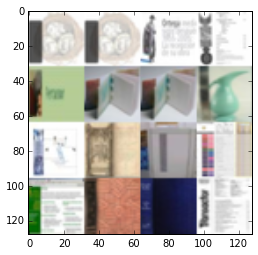

In [63]:
starttime = time.time()
opq_ret = opq_retrieval(query_ind)
print time.time() - starttime
plt.imshow(tile_images(opq_ret[:16]))
plt.show()

46.0673630238


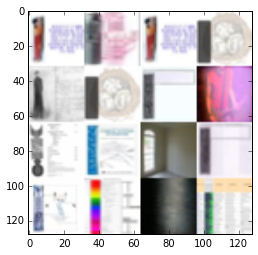

In [15]:
starttime = time.time()
opq_ret = opq_retrieval_assym(query_ind)
print time.time() - starttime
plt.imshow(tile_images(opq_ret[:16]))
plt.show()

# Estimate the approximation error for PQ and OPQ

In [38]:
pqY = np.zeros(X.shape)
for el in xrange(n):
    for subsp in xrange(c):
        pqY[el, subsp * m / c : (subsp + 1) * m / c] = pq_centroids[pq_codes[el, subsp], :, subsp]

In [39]:
opqY = np.zeros(X.shape)
for el in xrange(n):
    for subsp in xrange(c):
        opqY[el, subsp * m / c : (subsp + 1) * m / c] = opq_centroids[opq_codes[el, subsp], :, subsp]

In [40]:
print np.linalg.norm(X - pqY)

127.950780618


In [41]:
print np.linalg.norm(X.dot(R) - opqY)

130.625053925


In [21]:
import random
l = 1000
query_ind_calc = random.sample(range(n), l)
pq_recall = np.zeros(l)
opq_recall = np.zeros(l)

In [75]:
def pq_retrieve_calc(query):
    # finding nearest centroid
    q = X[query,:].reshape((1, X.shape[1]))
    coeffs = np.zeros(c)
    for i in xrange(c):
        coeffs[i] = cdist(q[:, i * m / c : (i + 1) * m / c], pq_centroids[:,:,i]).argmin()
    #print coeffs
    # calculating approx distances
    dist = {}
    for i in xrange(l):
        dist[query_ind_calc[i]] = pq_approx_dist(coeffs, pq_codes[query_ind_calc[i]])
    # returning result
    #print dist
    return np.array(sorted(dist, key = lambda x : dist[x]))

In [16]:
def pq_retrieve_calc_assym(query):
    # finding nearest centroid
    #print coeffs
    # calculating approx distances
    dist = {}
    for i in xrange(l):
        dist[query_ind_calc[i]] = pq_approx_dist_assym(X[query], pq_codes[query_ind_calc[i]])
    # returning result
    #print dist
    return np.array(sorted(dist, key = lambda x : dist[x]))

In [76]:
def opq_retrieval_calc(query):
    q = X[query,:].reshape((1, X.shape[1])).dot(R)
    coeffs = np.zeros(c)
    for i in xrange(c):
        coeffs[i] = cdist(q[:, i * m / c : (i + 1) * m / c], opq_centroids[:,:,i]).argmin()
    #print coeffs
    # calculating approx distances
    dist = {}
    for i in xrange(l):
        dist[query_ind_calc[i]] = opq_approx_dist(coeffs, opq_codes[query_ind_calc[i]])
    # returning result
    #print dist
    return np.array(sorted(dist, key = lambda x : dist[x]))

In [17]:
def opq_retrieval_calc_assym(query):
    #print coeffs
    # calculating approx distances
    dist = {}
    for i in xrange(l):
        dist[query_ind_calc[i]] = opq_approx_dist_assym(X[query], opq_codes[query_ind_calc[i]])
    # returning result
    #print dist
    return np.array(sorted(dist, key = lambda x : dist[x]))

In [18]:
def retrieve_calc(query_ind):
    query = X[query_ind,:].reshape((1, X.shape[1]))
    dist = {}
    for i in xrange(l):
        dist[query_ind_calc[i]] = cdist(query, X[query_ind_calc[i]].reshape((1,X.shape[1])))
    #print dist
    return np.array(sorted(dist, key = lambda x : dist[x]))

In [19]:
def comp_recall(retrieval, query, ground_truth):
    ret = retrieval(query)
    #print ret
    pos = np.flatnonzero(ret == ground_truth)[0]
    if (np.any(ret[:pos] == query)):
        pos = pos - 1
    recall = np.zeros(ret.shape)
    recall[pos:] = 1
    return recall

In [79]:
starttime = time.time()
for q in query_ind_calc:
    simple_ret = retrieve_calc(q)
    ground_truth = simple_ret[1]
    pq_recall +=  1.0/l * comp_recall(pq_retrieve_calc,  q, ground_truth)
    opq_recall += 1.0/l * comp_recall(opq_retrieval_calc, q, ground_truth)
print time.time() - starttime

1023.2234931


In [22]:
starttime = time.time()
for q in query_ind_calc:
    simple_ret = retrieve_calc(q)
    ground_truth = simple_ret[1]
    pq_recall +=  1.0/l * comp_recall(pq_retrieve_calc_assym,  q, ground_truth)
    opq_recall += 1.0/l * comp_recall(opq_retrieval_calc_assym, q, ground_truth)
print time.time() - starttime

988.611943007


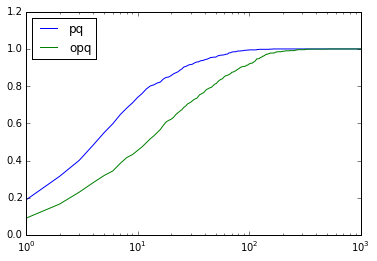

In [24]:
plt.plot(range(1,l+1), pq_recall, range(1,l+1), opq_recall)
plt.legend(('pq', 'opq'),'best')
plt.xscale('log')
plt.show()